# Image Data Example

This notebook demonstrates how to load, visualize, and manipulate Image data using the `fomo_sdk`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fomo_sdk.image.utils import load_fomo_image, project_lidar_on_image, CameraType
from fomo_sdk.tf.utils import FoMoTFTree
from importlib import resources

## 1. Load Data (.png)

Load some camera image files.

In [13]:
dataset_base_path = "data"
deployment = "2025-10-14"
trajectory = "red"
number_of_images = 3

image_data_zedx_left = load_fomo_image(
    dataset_base_path, deployment, trajectory, number_of_images, CameraType.ZEDX_LEFT
)
image_data_zedx_right = load_fomo_image(
    dataset_base_path, deployment, trajectory, number_of_images, CameraType.ZEDX_RIGHT
)
image_data_basler = load_fomo_image(
    dataset_base_path, deployment, trajectory, number_of_images, CameraType.BASLER
)
image_data = [image_data_zedx_left, image_data_zedx_right, image_data_basler]

## 2. Visualization

Plots the image mosaic

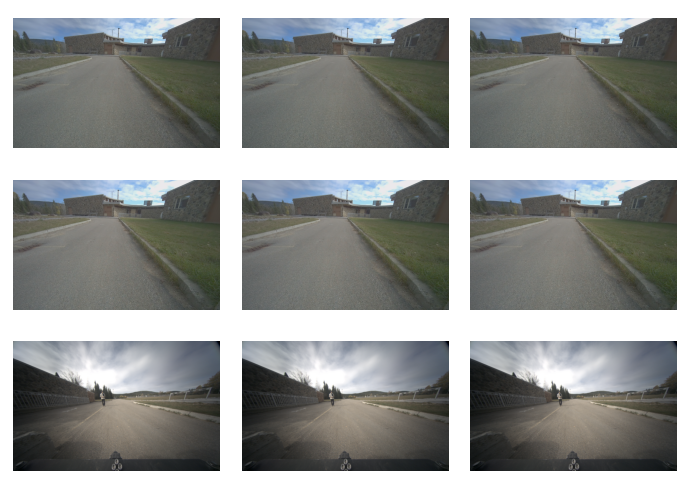

In [20]:
fig, axs = plt.subplots(nrows=number_of_images, ncols=len(image_data), figsize=(7, 5))
for i in range(0, number_of_images):
    for j in range(0, len(image_data)):
        axs[i, j].imshow(image_data[i][j][..., ::-1].astype("uint8"))
        axs[i, j].axis("off")
        axs[i, j].axis("equal")
plt.tight_layout()
plt.show()

### Lidar point projections
Project robosense lidar point clouds on top of an image. No motion compensation is applied.

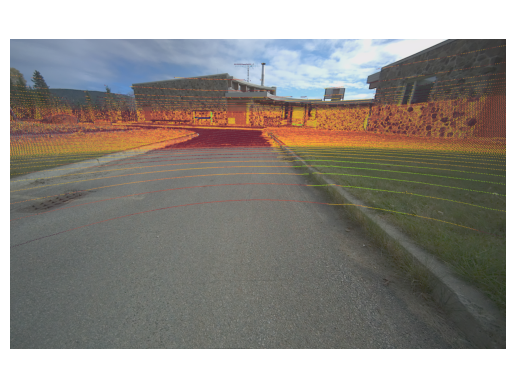

In [21]:
from fomo_sdk.lidar.utils import load_fomo_lidar, transform_points
# TODO load the closest lidar scan to the first image
# TODO fix the tfs

image_zedx_left = image_data[0][0]  # first image from the left camera
data_robosense = load_fomo_lidar(
    dataset_base_path, deployment, trajectory, load_robosense=True
)

# transform leishen to robosense frame
tf_tree = FoMoTFTree()
tf = tf_tree.get_transform(from_frame="robosense", to_frame="zedx_left")
data_robosense = transform_points(data_robosense, np.linalg.inv(tf))

intrinsics_left_filepath = resources.files("fomo_sdk.data").joinpath(
    "calib/zedx_left.json"
)
image_points = project_lidar_on_image(
    image_zedx_left, data_robosense, intrinsics_left_filepath
)
fig = plt.figure()
plt.imshow(image_points[..., ::-1].astype("uint8"))
plt.axis("off")
plt.axis("equal")
plt.show()


Similarly, we can project points from the Leishen lidar

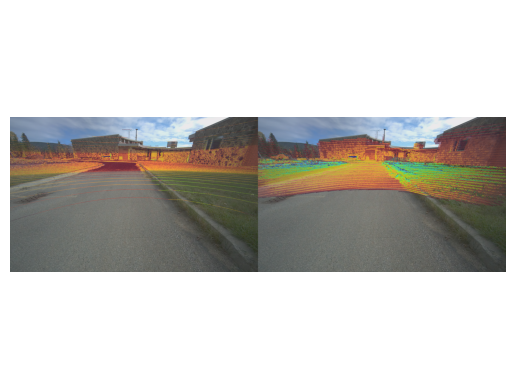

In [22]:
from fomo_sdk.lidar.utils import load_fomo_lidar, transform_points
# TODO load the closest lidar scan to the first image
# TODO fix the tfs

image_zedx_right = image_data[0][1]  # first image from the right camera
data_leishen = load_fomo_lidar(
    dataset_base_path, deployment, trajectory, load_robosense=False
)

# transform leishen to robosense frame
tf_tree = FoMoTFTree()
tf = tf_tree.get_transform(from_frame="leishen", to_frame="zedx_right")
data_leishen = transform_points(data_leishen, np.linalg.inv(tf))

intrinsics_right_filepath = resources.files("fomo_sdk.data").joinpath(
    "calib/zedx_right.json"
)
image_points_right = project_lidar_on_image(
    image_zedx_right, data_leishen, intrinsics_right_filepath
)
combined_image_points = np.hstack((image_points, image_points_right))
fig = plt.figure()
plt.imshow(combined_image_points[..., ::-1].astype("uint8"))
plt.axis("off")
plt.axis("equal")
plt.show()

## 4. Loading from Rosbag (TODO)

In [ ]:
# Example code for loading from rosbag
# from rosbags.rosbag2 import Reader
# from rosbags.serde import deserialize_cdr, ros1_to_cdr
# from fomo_sdk.lidar.utils import downsample_pointcloud

# bag_path = "path/to/your/rosbag"
# if os.path.exists(bag_path):
#     with Reader(bag_path) as reader:
#         for connection, timestamp, rawdata in reader.messages():
#             if connection.topic == "/your/lidar/topic":
#                 msg = deserialize_cdr(rawdata, connection.msgtype)
#                 # Process msg here
#                 print(f"Found message at {timestamp}")
#                 break